In [1]:
from typing import Optional

import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer, AerSimulator
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    thermal_relaxation_error,
)
from qiskit_aer.primitives import Sampler

# 7 - Noise

## Exercise 1
Define a function that, given a circuit as input, allows you to implement the different types of noise studied in this session.

Para facilitar la definición de una función `create_noise_model` como la indicada por el enunciado, implementamos primero las siguientes funciones, cada una de ellas implementando un tipo de ruido.

Esta función `create_noise_model` orquestará la creación de un `NoiseModel`, delegando la lógica específica a funciones auxiliares:

- **Errores de relajación térmica.** La función `get_thermal_error` genera errores de relajación térmica basados en los tiempos T1, T2, y la duración de las puertas.

In [2]:
def get_thermal_error(
    t1: Optional[float],
    t2: Optional[float],
    gate_time: Optional[float],
    num_qubits: int = 1,
) -> Optional[QuantumError]:
    if t1 is None or t2 is None or gate_time is None:
        return None

    error = thermal_relaxation_error(t1, t2, gate_time)

    if num_qubits == 2:
        # Para puertas de 2 qubits, aplicamos el error a ambos (producto tensorial)
        error = error.tensor(thermal_relaxation_error(t1, t2, gate_time))

    return error

- **Errores de puertas.** La función `get_depolarizing_error` crea un canal de despolarización que simula imperfecciones en la ejecución de las puertas lógicas.

In [3]:
def get_depolarizing_error(
    prob: Optional[float], num_qubits: int = 1
) -> Optional[QuantumError]:
    if prob is None or prob == 0:
        return None
    return depolarizing_error(prob, num_qubits)

- **Errores de lectura.** La función `get_radout_error` define una matriz de probabilidades para modelar errores clásicos de flip de bit durante la medición.

In [4]:
def get_readout_error(prob: Optional[float]) -> Optional[ReadoutError]:
    if prob is None or prob == 0:
        return None
    # Probabilidades: [[P(0|0), P(0|1)], [P(1|0), P(1|1)]]
    return ReadoutError([[1 - prob, prob], [prob, 1 - prob]])

- En un dispositivo cuántico real, una misma puerta lógica puede sufrir simultáneamente relajación térmica y despolarización. Por lo tanto, definimos también una función `combine_errors` para integrar múltiples fuentes de ruido en un único objeto.

In [5]:
def combine_errors(
    error_a: Optional[QuantumError], error_b: Optional[QuantumError]
) -> Optional[QuantumError]:
    if error_a is None:
        return error_b
    if error_b is None:
        return error_a
    return error_a.compose(error_b)

Con todos los tipos de error ya definidos, podemos definir una función `create_noise_model` como la que indica el enunciado:

In [6]:
def create_noise_model(
    t1: Optional[float] = None,
    t2: Optional[float] = None,
    time_1q: Optional[float] = None,
    time_2q: Optional[float] = None,
    p_depol_1q: Optional[float] = None,
    p_depol_2q: Optional[float] = None,
    p_readout: Optional[float] = None,
) -> NoiseModel:
    noise_model = NoiseModel()

    # --- 1. Configuración de Errores de 1 Qubit ---
    therm_1q = get_thermal_error(t1, t2, time_1q, num_qubits=1)
    depol_1q = get_depolarizing_error(p_depol_1q, num_qubits=1)

    error_1q = combine_errors(therm_1q, depol_1q)

    if error_1q:
        noise_model.add_all_qubit_quantum_error(
            error_1q, ["u1", "u2", "u3", "rz", "sx", "x", "h", "id"]
        )

    # --- 2. Configuración de Errores de 2 Qubits ---
    therm_2q = get_thermal_error(t1, t2, time_2q, num_qubits=2)
    depol_2q = get_depolarizing_error(p_depol_2q, num_qubits=2)

    error_2q = combine_errors(therm_2q, depol_2q)

    if error_2q:
        noise_model.add_all_qubit_quantum_error(error_2q, ["cx"])

    # --- 3. Configuración de Error de Lectura ---
    readout_err = get_readout_error(p_readout)

    if readout_err:
        noise_model.add_all_qubit_readout_error(readout_err)

    return noise_model

## Exercise 2

Test it with basic circuits (3-4 qubits) and comment on the results for different noise values/combinations.

Definimos un circuito básico

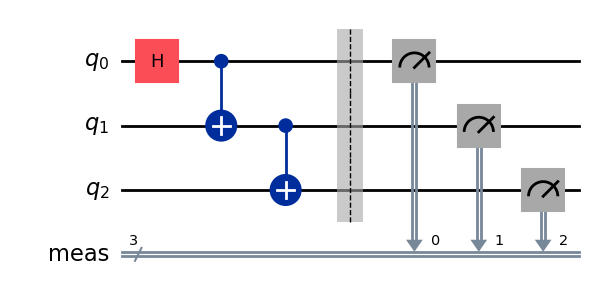

In [7]:
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.measure_all()
qc.draw("mpl")

Primero, ejecutamos este circuito sin ruido para ver cual sería el resultado teórico:

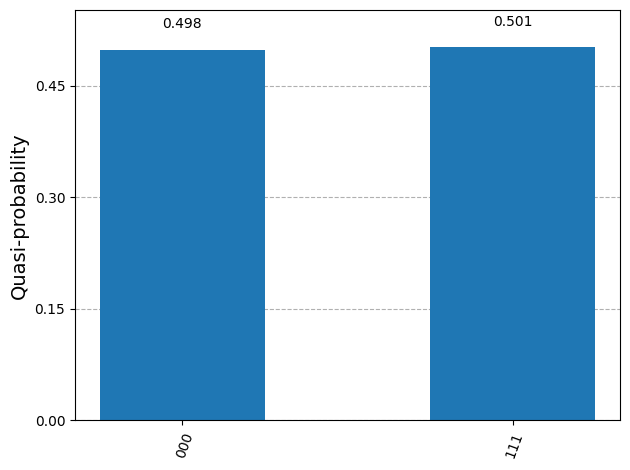

In [8]:
sampler = Sampler()
result = sampler.run([qc], shots=4000).result()
dist = result.quasi_dists[0]
plot_histogram(dist.binary_probabilities())

A continuación, definimos el modelo de ruido y ejecutamos la simulación. Es importante destacar que hemos configurado un entorno con una tasa de error intencionalmente alta, bastante superior a la de los procesadores cuánticos actuales (como los de IBM).

Esto se debe a que, dado que el circuito empleado tiene muy poca profundidad, necesitamos tiempos de coherencia reducidos para que se produzca una tasa significativa de errores y así poder visualizar claramente la decoherencia en el histograma de salida.

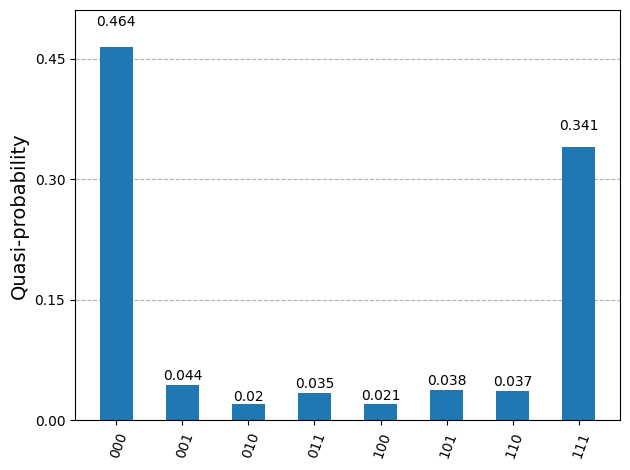

In [9]:
noise_model = create_noise_model(
    t1=50e-7,
    t2=70e-7,
    time_1q=35e-9,
    time_2q=300e-9,
    p_depol_1q=0.001,
    p_depol_2q=0.01,
    p_readout=0.03,
)
sampler = Sampler(backend_options={"noise_model": noise_model})
result = sampler.run([qc], shots=4000).result()
dist = result.quasi_dists[0]
plot_histogram(dist.binary_probabilities())

Como podemos ver, claramente, los resultados obtenidos al añadir el modelo de ruido son muy distintos a los del simulador ideal.

En primer lugar, se observa una pérdida general de la fidelidad, pues aparecen estados prohibidos en aproximadamente el 20% de las ejecuciones. La presencia de estos estados es consecuencia directa de la combinación de errores de despolarización en las puertas lógicas y errores de lectura.

En segundo lugar, vemos que, a diferencia del simulador ideal, donde los estados $|000 \rangle$ y $|111 \rangle$ son equiprobables, aquí obtenemos $|000 \rangle$ en el 45% de los casos, frente a solo un 35% del estado $|111 \rangle$. Esta asimetría se debe al impacto del valor extremadamente bajo elegido para la relajación térmica longitudinal (t1). Debido a este fenómeno, los qubits excitados tienden a perder energía a lo largo del tiempo y, eventualmente, caen hacia el estado $|0 \rangle$.